In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sps
import math
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

from utils.extract_data import get_false_quarantine, get_Rt, absolute_file_paths, get_human_rec_levels, get_human_states, get_data

In [2]:
def get_all_false(filename=None, data=None, normalized=False):
    data = get_data(filename, data)
    intervention_day = data['intervention_day']
    if intervention_day<0:
        intervention_day=0
    states = get_human_states(data=data)
    states = states[:, intervention_day:]
    rec_levels = get_human_rec_levels(data=data, normalized=normalized)
    
    false_level3 = np.sum(((states==0) | (states==3)) & (rec_levels==3), axis=0)
    false_level2 = np.sum(((states==0) | (states==3)) & (rec_levels==2), axis=0)
    false_level1 = np.sum(((states==0) | (states==3)) & (rec_levels==1), axis=0)
    false_level1_above = np.sum(((states==0) | (states==3)) & ((rec_levels==1) | (rec_levels==2) | (rec_levels==3)), axis=0)
    false_level2_above = np.sum(((states==0) | (states==3)) & ((rec_levels==2) | (rec_levels==3)), axis=0)
    return false_level3/states.shape[0], false_level2/states.shape[0], false_level1/states.shape[0], false_level1_above/states.shape[0], false_level2_above/states.shape[0]

def get_proxy_r(data):
    total_infected = 0
    for k in data['humans_state'].keys():
        total_infected += any(z== 'I' for z in data['humans_state'][k][5:])
    return sum(data['cases_per_day'][5:])/total_infected

def get_fq_r(filename, normalized=False):
    data = pickle.load(open(filename, "rb"))
    
    f3, f2, f1, f1_up, f2_up = get_all_false(data=data, normalized=normalized)
    x = [i[-5:].mean() for i in [f3, f2, f1, f1_up, f2_up]]

    intervention_day = data['intervention_day']
    od = np.mean(data['outside_daily_contacts'][intervention_day:])
    ec = data['effective_contacts_since_intervention']
       
    # percent_infected
    y = sum(data['cases_per_day'])/data['n_humans']
    
    # R
    z = get_effective_R(data) 
    
    # proxy_r 
    a = get_proxy_r(data)
    
    return x, y, z, a, od, ec

def get_mean_fq_r(filenames, normalized=False):
    _tmp = sorted(filenames, key= lambda x: int(x.split("/") [-1].split("_")[5]))
    metrics = {'f3':[], 'f2':[], 'f1':[], 'f1_up':[], 'f2_up':[], 'percent_infected':[], 'r':[], \
                       'proxy_r':[], 'outside_daily_contacts':[], 'effective_contacts':[]}
    for filename in _tmp:
        x,y,z,a, od, ec = get_fq_r(filename, normalized=normalized)
        metrics['f3'].append(x[0])
        metrics['f2'].append(x[1])
        metrics['f1'].append(x[2])
        metrics['f1_up'].append(x[3])
        metrics['f2_up'].append(x[4])
        metrics['percent_infected'].append(y)
        metrics['r'].append(z)
        metrics['proxy_r'].append(a)
        metrics['outside_daily_contacts'].append(od)
        metrics['effective_contacts'].append(ec)
        
    return metrics

def get_effective_R(data):
    GT = data['generation_times']
    a = 4
    b = 0.5
    window_size=5
    ws = [sps.gamma.pdf(x, a=GT, loc=0, scale=0.9) for x in range(window_size)]
    last_ws = ws[::-1]
    cases_per_day = data['cases_per_day']

    lambda_s = []
    rt = []
    for i in range(len(cases_per_day)):
        if i <  window_size:
            last_Is = cases_per_day[:i]
        else:
            last_Is = cases_per_day[(i-window_size):i]

        lambda_s.append(sum(x*y for x,y in zip(last_Is, last_ws)))
        last_lambda_s = sum(lambda_s[-window_size:])
        rt.append((a + sum(last_Is)) / (1/b + last_lambda_s))
    return np.mean(rt[-5:])

def get_all(filename_types, labels, normalized=False):
    _rows = []
    for i, filenames in enumerate(filename_types):
        print(labels[i], len(filenames))
        metrics = get_mean_fq_r(filenames, normalized=normalized)
        for key, val in metrics.items():
            _rows.append([labels[i], key] + val)
    return _rows

In [5]:
rows = []
# dir = "../src/covid19sim/tune/.."
dir = "/Users/pgupta/Workspace/covid/develop/"

In [6]:

unmitigated = absolute_file_paths(f"{dir}/unmitigated")
rows += get_all([unmitigated], ['unmitigated'])

bdt1 = absolute_file_paths(f"{dir}/bdt1")
bdt1_70 = absolute_file_paths(f"{dir}/bdt1_70")
bdt1_60 = absolute_file_paths(f"{dir}/bdt1_60")
bdt1_40 = absolute_file_paths(f"{dir}/bdt1_40")
rows += get_all([bdt1, bdt1_70, bdt1_60, bdt1_40], ["bdt1", "bdt1_70", "bdt1_60", "bdt1_40"])

bdt2 = absolute_file_paths(f"{dir}/bdt2")
bdt2_70 = absolute_file_paths(f"{dir}/bdt2_70")
bdt2_60 = absolute_file_paths(f"{dir}/bdt2_60")
bdt2_40 = absolute_file_paths(f"{dir}/bdt2_40")
rows += get_all([bdt2, bdt2_70, bdt2_60, bdt2_40], ["bdt2", "bdt2_70", "bdt2_60", "bdt2_40"])


unmitigated 12
bdt1 12
bdt1_70 12
bdt1_60 12
bdt1_40 12
bdt2 12
bdt2_70 12
bdt2_60 12
bdt2_40 12


In [7]:
heuristic = absolute_file_paths(f"{dir}/heuristic")
heuristic_70 = absolute_file_paths(f"{dir}/heuristic_70")
heuristic_60 = absolute_file_paths(f"{dir}/heuristic_60")
heuristic_40 = absolute_file_paths(f"{dir}/heuristic_40")

heuristics = [heuristic, heuristic_70, heuristic_60, heuristic_40]
heuristic_labels = ['heuristic', 'heuristic_70', 'heuristic_60', 'heuristic_40']
rows += get_all(heuristics, heuristic_labels)

heuristic 12
heuristic_70 12
heuristic_60 12
heuristic_40 12


In [8]:
# normalized curves for heuristic
# 
bdt1_norm_heuristic = absolute_file_paths(f"{dir}/bdt1_norm_heuristic")
bdt1_70_norm_heuristic_70 = absolute_file_paths(f"{dir}/bdt1_70_norm_heuristic_70")
bdt1_60_norm_heuristic_60 = absolute_file_paths(f"{dir}/bdt1_60_norm_heuristic_60")
bdt1_40_norm_heuristic_40 = absolute_file_paths(f"{dir}/bdt1_40_norm_heuristic_40")

norm_bdt1 = [bdt1_norm_heuristic, bdt1_70_norm_heuristic_70, bdt1_60_norm_heuristic_60, bdt1_40_norm_heuristic_40]
norm_bdt1_labels = ['bdt1_norm_heuristic', 'bdt1_70_norm_heuristic_70', 'bdt1_60_norm_heuristic_60', 'bdt1_40_norm_heuristic_40']
rows += get_all(norm_bdt1, norm_bdt1_labels, normalized=True)

# 
bdt2_norm_heuristic = absolute_file_paths(f"{dir}/bdt2_norm_heuristic")
bdt2_70_norm_heuristic_70 = absolute_file_paths(f"{dir}/bdt2_70_norm_heuristic_70")
bdt2_60_norm_heuristic_60 = absolute_file_paths(f"{dir}/bdt2_60_norm_heuristic_60")
bdt2_40_norm_heuristic_40 = absolute_file_paths(f"{dir}/bdt2_40_norm_heuristic_40")

# norm_bdt2 = [bdt2_norm, bdt2_70_norm, bdt2_60_norm, bdt2_40_norm]
# norm_bdt2_labels = ['bdt2_norm', 'bdt2_70_norm', 'bdt2_60_norm', 'bdt2_40_norm']
norm_bdt2 = [bdt2_norm_heuristic, bdt2_70_norm_heuristic_70, bdt2_60_norm_heuristic_60, bdt2_40_norm_heuristic_40]
norm_bdt2_labels = ['bdt2_norm_heuristic', 'bdt2_70_norm_heuristic_70', 'bdt2_60_norm_heuristic_60', 'bdt2_40_norm_heuristic_40']
rows += get_all(norm_bdt2, norm_bdt2_labels, normalized=True)

bdt1_norm_heuristic 12
bdt1_70_norm_heuristic_70 12
bdt1_60_norm_heuristic_60 12
bdt1_40_norm_heuristic_40 0
bdt2_norm_heuristic 12
bdt2_70_norm_heuristic_70 12
bdt2_60_norm_heuristic_60 12
bdt2_40_norm_heuristic_40 0


In [10]:
#
transformer = absolute_file_paths(f"{dir}/transformer")
transformer_70 = absolute_file_paths(f"{dir}/transformer_70")
transformer_60 = absolute_file_paths(f"{dir}/transformer_60")
transformer_40 = absolute_file_paths(f"{dir}/transformer_40")

transformers = [transformer, transformer_60, transformer_40, transformer_70]
transformer_labels = ['transformer', 'transformer_60', 'transformer_40', 'transformer_70']
rows += get_all(transformers, transformer_labels)

transformer 12
transformer_60 12
transformer_40 12
transformer_70 12


In [11]:
# normalized curves for transformer
# 
bdt1_norm_transformer = absolute_file_paths(f"{dir}/bdt1_norm_transformer")
bdt1_70_norm_transformer_70 = absolute_file_paths(f"{dir}/bdt1_70_norm_transformer_70")
bdt1_60_norm_transformer_60 = absolute_file_paths(f"{dir}/bdt1_60_norm_transformer_60")
bdt1_40_norm_transformer_40 = absolute_file_paths(f"{dir}/bdt1_40_norm_transformer_40")

norm_bdt1 = [bdt1_norm_transformer, bdt1_70_norm_transformer_70, bdt1_60_norm_transformer_60, bdt1_40_norm_transformer_40]
norm_bdt1_labels = ['bdt1_norm_transformer', 'bdt1_70_norm_transformer_70', 'bdt1_60_norm_transformer_60', 'bdt1_40_norm_transformer_40']
rows += get_all(norm_bdt1, norm_bdt1_labels, normalized=True)

# 
bdt2_norm_transformer = absolute_file_paths(f"{dir}/bdt2_norm_transformer")
bdt2_70_norm_transformer_70 = absolute_file_paths(f"{dir}/bdt2_70_norm_transformer_70")
bdt2_60_norm_transformer_60 = absolute_file_paths(f"{dir}/bdt2_60_norm_transformer_60")
bdt2_40_norm_transformer_40 = absolute_file_paths(f"{dir}/bdt2_40_norm_transformer_40")

# norm_bdt2 = [bdt2_norm, bdt2_70_norm, bdt2_60_norm, bdt2_40_norm]
# norm_bdt2_labels = ['bdt2_norm', 'bdt2_70_norm', 'bdt2_60_norm', 'bdt2_40_norm']
norm_bdt2 = [bdt2_norm_transformer, bdt2_70_norm_transformer_70, bdt2_60_norm_transformer_60, bdt2_40_norm_transformer_40]
norm_bdt2_labels = ['bdt2_norm_transformer', 'bdt2_70_norm_transformer_70', 'bdt2_60_norm_transformer_60', 'bdt2_40_norm_transformer_40']
rows += get_all(norm_bdt2, norm_bdt2_labels, normalized=True)

bdt1_norm_transformer 12
bdt1_70_norm_transformer_70 12
bdt1_60_norm_transformer_60 12
bdt1_40_norm_transformer_40 12
bdt2_norm_transformer 12
bdt2_70_norm_transformer_70 12
bdt2_60_norm_transformer_60 12
bdt2_40_norm_transformer_40 12


In [7]:
# linear regression
linear = absolute_file_paths(f"{dir}/linear")
linear_70 = absolute_file_paths(f"{dir}/linear_70")
linear_40 = absolute_file_paths(f"{dir}/linear_40")
linear_60 = absolute_file_paths(f"{dir}/linear_60")

linears = [linear, linear_70,  linear_60, linear_40,]
linear_labels = ['linear', 'linear_70', 'linear_60', 'linear_40']
rows += get_all(linears, linear_labels)

linear 4
linear_60 4
linear_40 4
linear_70 4


In [12]:
# oracle 
#
oracle = absolute_file_paths(f"{dir}/oracle")
oracle_70 = absolute_file_paths(f"{dir}/oracle_70")
oracle_60 = absolute_file_paths(f"{dir}/oracle_60")
oracle_40 = absolute_file_paths(f"{dir}/oracle_40")

oracles = [oracle, oracle_70, oracle_60, oracle_40]
oracle_labels = ['oracle', 'oracle_70', 'oracle_60', 'oracle_40']
rows += get_all(oracles, oracle_labels)

oracle 16
oracle_70 12
oracle_60 12
oracle_40 12


In [19]:
import copy
all_rows = copy.deepcopy(rows)

In [21]:
oracle = absolute_file_paths(f"{dir}/oracle")
rows += get_all([oracle], ['oracle'])

oracle 12


In [23]:
n_seeds = len(unmitigated)
seed_columns = list(range(n_seeds))
data = pd.DataFrame(rows, columns=['type', 'metric'] + seed_columns)
data['mean'] = data[seed_columns].mean(axis=1)
data['stderr'] = data[seed_columns].sem(axis=1)

In [24]:
pd.set_option("display.max_rows", None)
data

type                  metric          0  \
0                    unmitigated                      f3   0.000000   
1                    unmitigated                      f2   0.000000   
2                    unmitigated                      f1   0.000000   
3                    unmitigated                   f1_up   0.000000   
4                    unmitigated                   f2_up   0.000000   
5                    unmitigated        percent_infected   0.761000   
6                    unmitigated                       r   1.789514   
7                    unmitigated                 proxy_r   1.203612   
8                    unmitigated  outside_daily_contacts   0.864000   
9                    unmitigated      effective_contacts  16.642720   
10                          bdt1                      f3   0.309800   
11                          bdt1                      f2   0.000000   
12                          bdt1                      f1   0.000000   
13                          bdt1                   f1_up   0.309800   
14                          bdt1                   f2_up   0.309800   
15                          bdt1        percent_infected   0.182000   
16                          bdt1                       r   2.153727   
17                          bdt1                 proxy_r   1.031447   
18                          bdt1  outside_daily_contacts   2.787632   
19                          bdt1      effective_contacts   9.990800   
20                       bdt1_70                      f3   0.145400   
21                       bdt1_70                      f2   0.000000   
22                       bdt1_70                      f1   0.000000   
23                       bdt1_70                   f1_up   0.145400   
24                       bdt1_70                   f2_up   0.145400   
25                       bdt1_70        percent_infected   0.326000   
26                       bdt1_70                       r   2.297896   
27                       bdt1_70                 proxy_r   1.305085   
28                       bdt1_70  outside_daily_contacts   4.166947   
29                       bdt1_70      effective_contacts  13.070200   
30                       bdt1_60                      f3   0.119000   
31                       bdt1_60                      f2   0.000000   
32                       bdt1_60                      f1   0.000000   
33                       bdt1_60                   f1_up   0.119000   
34                       bdt1_60                   f2_up   0.119000   
35                       bdt1_60        percent_infected   0.367000   
36                       bdt1_60                       r   2.491664   
37                       bdt1_60                 proxy_r   1.297398   
38                       bdt1_60  outside_daily_contacts   4.499105   
39                       bdt1_60      effective_contacts  13.917950   
40                       bdt1_40                      f3   0.049200   
41                       bdt1_40                      f2   0.000000   
42                       bdt1_40                      f1   0.000000   
43                       bdt1_40                   f1_up   0.049200   
44                       bdt1_40                   f2_up   0.049200   
45                       bdt1_40        percent_infected   0.333000   
46                       bdt1_40                       r   2.628524   
47                       bdt1_40                 proxy_r   1.357759   
48                       bdt1_40  outside_daily_contacts   4.695842   
49                       bdt1_40      effective_contacts  14.591350   
50                          bdt2                      f3   0.825600   
51                          bdt2                      f2   0.000000   
52                          bdt2                      f1   0.000000   
53                          bdt2                   f1_up   0.825600   
54                          bdt2                   f2_up   0.825600   
55                          bdt2        percent_infe

In [32]:
import math
def get_metrics(data, label, metric):
    tmp = data[(data['type'] == label) & (data['metric'] == metric)]
    return tmp['mean'], tmp['stderr']

def plot_all_metrics(axs, data, label, color, marker, xmetrics, ymetric, parent_color=None):
    alpha = 1.0
    if parent_color:
        alpha=0.4
    for axis_idx, xmetric in enumerate(xmetrics):
        x, xe = get_metrics(data, label, xmetric)
        y, ye = get_metrics(data, label, ymetric)
        if parent_color:
            axs[axis_idx].scatter(x=x,y=y, color=parent_color, marker="o", s=20*4*2, alpha=0.5)
        axs[axis_idx].errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                         capsize=capsize, c=color, marker=marker, ms=ms, label=label, alpha=alpha)
    return axs

def get_xlabel(xmetric):
    if xmetric == "f3":
        return "False level-3"
    if xmetric == "f2":
        return "False level-2"
    if xmetric == "f1":
        return "False level-1"
    if xmetric == "f2_up":
        return "False level >= 2"
    if xmetric == "effective_contacts":
        return "Effective Contacts"
    if xmetric == "outside_daily_contacts":
        return "Outside Daily Contacts"

In [33]:
# save data to avoid data loss in the middle of plotting
data.to_csv("extracted_data.csv")

# Plot all metrics

In [30]:
############
### /!\ Ordering should be consistent everywhere. i.e. _70, _60, _40
############

xmetrics = ['f3', 'f2', 'f1', 'f2_up', 'effective_contacts', 'outside_daily_contacts']
ymetric = "percent_infected"

ms = 6*2*1.5
capsize = 4
markers = ['P', 's', 'X', 'd', '.']
colormap = ["#34495e",  "mediumvioletred", "orangered", "royalblue", "darkorange", "green", "red"]


fig, axs = plt.subplots(nrows=math.ceil(len(xmetrics) / 2), ncols=2, figsize=(30,30), dpi=500, sharey=True)
axs = [i for j in axs for i in j]

#
plot_all_metrics(axs, data, "unmitigated", colormap[0], markers[0], xmetrics, ymetric)

#
idx = 1
for i, label in enumerate(['bdt1', 'bdt1_70','bdt1_60', 'bdt1_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)


#
idx = 1
for i, label in enumerate(['bdt1', 'bdt1_70','bdt1_60', 'bdt1_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)

#
idx = 2
for i,label in enumerate(['bdt2', 'bdt2_70','bdt2_60', 'bdt2_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)

#
heuristic_idx = 3
for i, label in enumerate(['heuristic', 'heuristic_70', 'heuristic_60', 'heuristic_40']):
    plot_all_metrics(axs, data, label, colormap[heuristic_idx], markers[i], xmetrics, ymetric)

transformer_idx = 4
for i, label in enumerate(['transformer', 'transformer_70', 'transformer_60', 'transformer_40']):
    plot_all_metrics(axs, data, label, colormap[transformer_idx], markers[i], xmetrics, ymetric)

idx = 5
for i, label in enumerate(['oracle', 'oracle_70', 'oracle_60', 'oracle_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)


# normalized
## heuristic
idx = 1
for i, label in enumerate(['bdt1_norm_heuristic', 'bdt1_70_norm_heuristic_70','bdt1_60_norm_heuristic_60', 'bdt1_40_norm_heuristic_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric, parent_color=colormap[heuristic_idx])

#
idx = 2
for i,label in enumerate(['bdt2_norm_heuristic', 'bdt2_70_norm_heuristic_70','bdt2_60_norm_heuristic_60', 'bdt2_40_norm_heuristic_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric, parent_color=colormap[heuristic_idx])

# normalized
## transformer
idx = 1
for i, label in enumerate(['bdt1_norm_transformer', 'bdt1_70_norm_transformer_70','bdt1_60_norm_transformer_60', 'bdt1_40_norm_transformer_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric, parent_color=colormap[transformer_idx])

#
idx = 2
for i,label in enumerate(['bdt2_norm_transformer', 'bdt2_70_norm_transformer_70','bdt2_60_norm_transformer_60', 'bdt2_40_norm_transformer_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric, parent_color=colormap[transformer_idx])


idx = 6
for i, label in enumerate(['linear_70', 'linear_60', 'linear_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)

# legends
legend = [
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor=colormap[0], markersize=15, label='Unmitigated'),
    Line2D([0], [0], color='none', lw=2, marker='P', markerfacecolor='black', markersize=10, label='100%$^*$ adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='mediumvioletred', markersize=15, label='1st-order Binary Tracing'),
    Line2D([0], [0], color='none', lw=2, marker='s', markerfacecolor='black', markersize=10, label='70% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='orangered', markersize=15, label='2nd Order Binary Tracing'),
    Line2D([0], [0], color='none', lw=2, marker='X', markerfacecolor='black', markersize=10, label='60% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='royalblue', markersize=15, label='heuristic'),
    Line2D([0], [0], color='none', lw=2, marker='d', markerfacecolor='black', markersize=10, label='40% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='darkorange', markersize=15, label='Transformer'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='green', markersize=15, label='oracle'),
]
lgd = fig.legend(handles=legend, loc='upper center', ncol=idx+1, fontsize=30, bbox_to_anchor=(0.5,1.08))

# grids
for axis_id, ax in enumerate(axs):
    ax.grid(True, axis='x', alpha=0.3)
    ax.grid(True, axis='y', alpha=0.3)

    ax.set_xlabel(get_xlabel(xmetrics[axis_id]), size=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(30)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(30)

# ylabel
if ymetric == "percent_infected":
    ylabel = 'Fraction infected'
elif ymetric == "proxy_r":
    ylabel = 'Proxy $\hat{R_t}$'
elif ymetric == "r":
    ylabel = '$R_t$'
txt = fig.text(-0.05, 0.5, ylabel, va='center', rotation='vertical', size=50)

if ymetric in ["proxy_r", "r"]:
    for ax in axs:
        ax.plot([0, 1.0], [1.0, 1.0], '-.', c="gray", alpha=0.3, label='Rt = 1.0')

fig.suptitle("Comparison of tracing methods across different adoption rates", fontsize=50, y=1.1)

plt.tight_layout()

fig.savefig("pareto", dpi=300, bbox_extra_artists=(lgd,txt), bbox_inches='tight')
print("done...")


TypeError: plot_all_metrics() got an unexpected keyword argument 'parent_color'

# plot only one metric

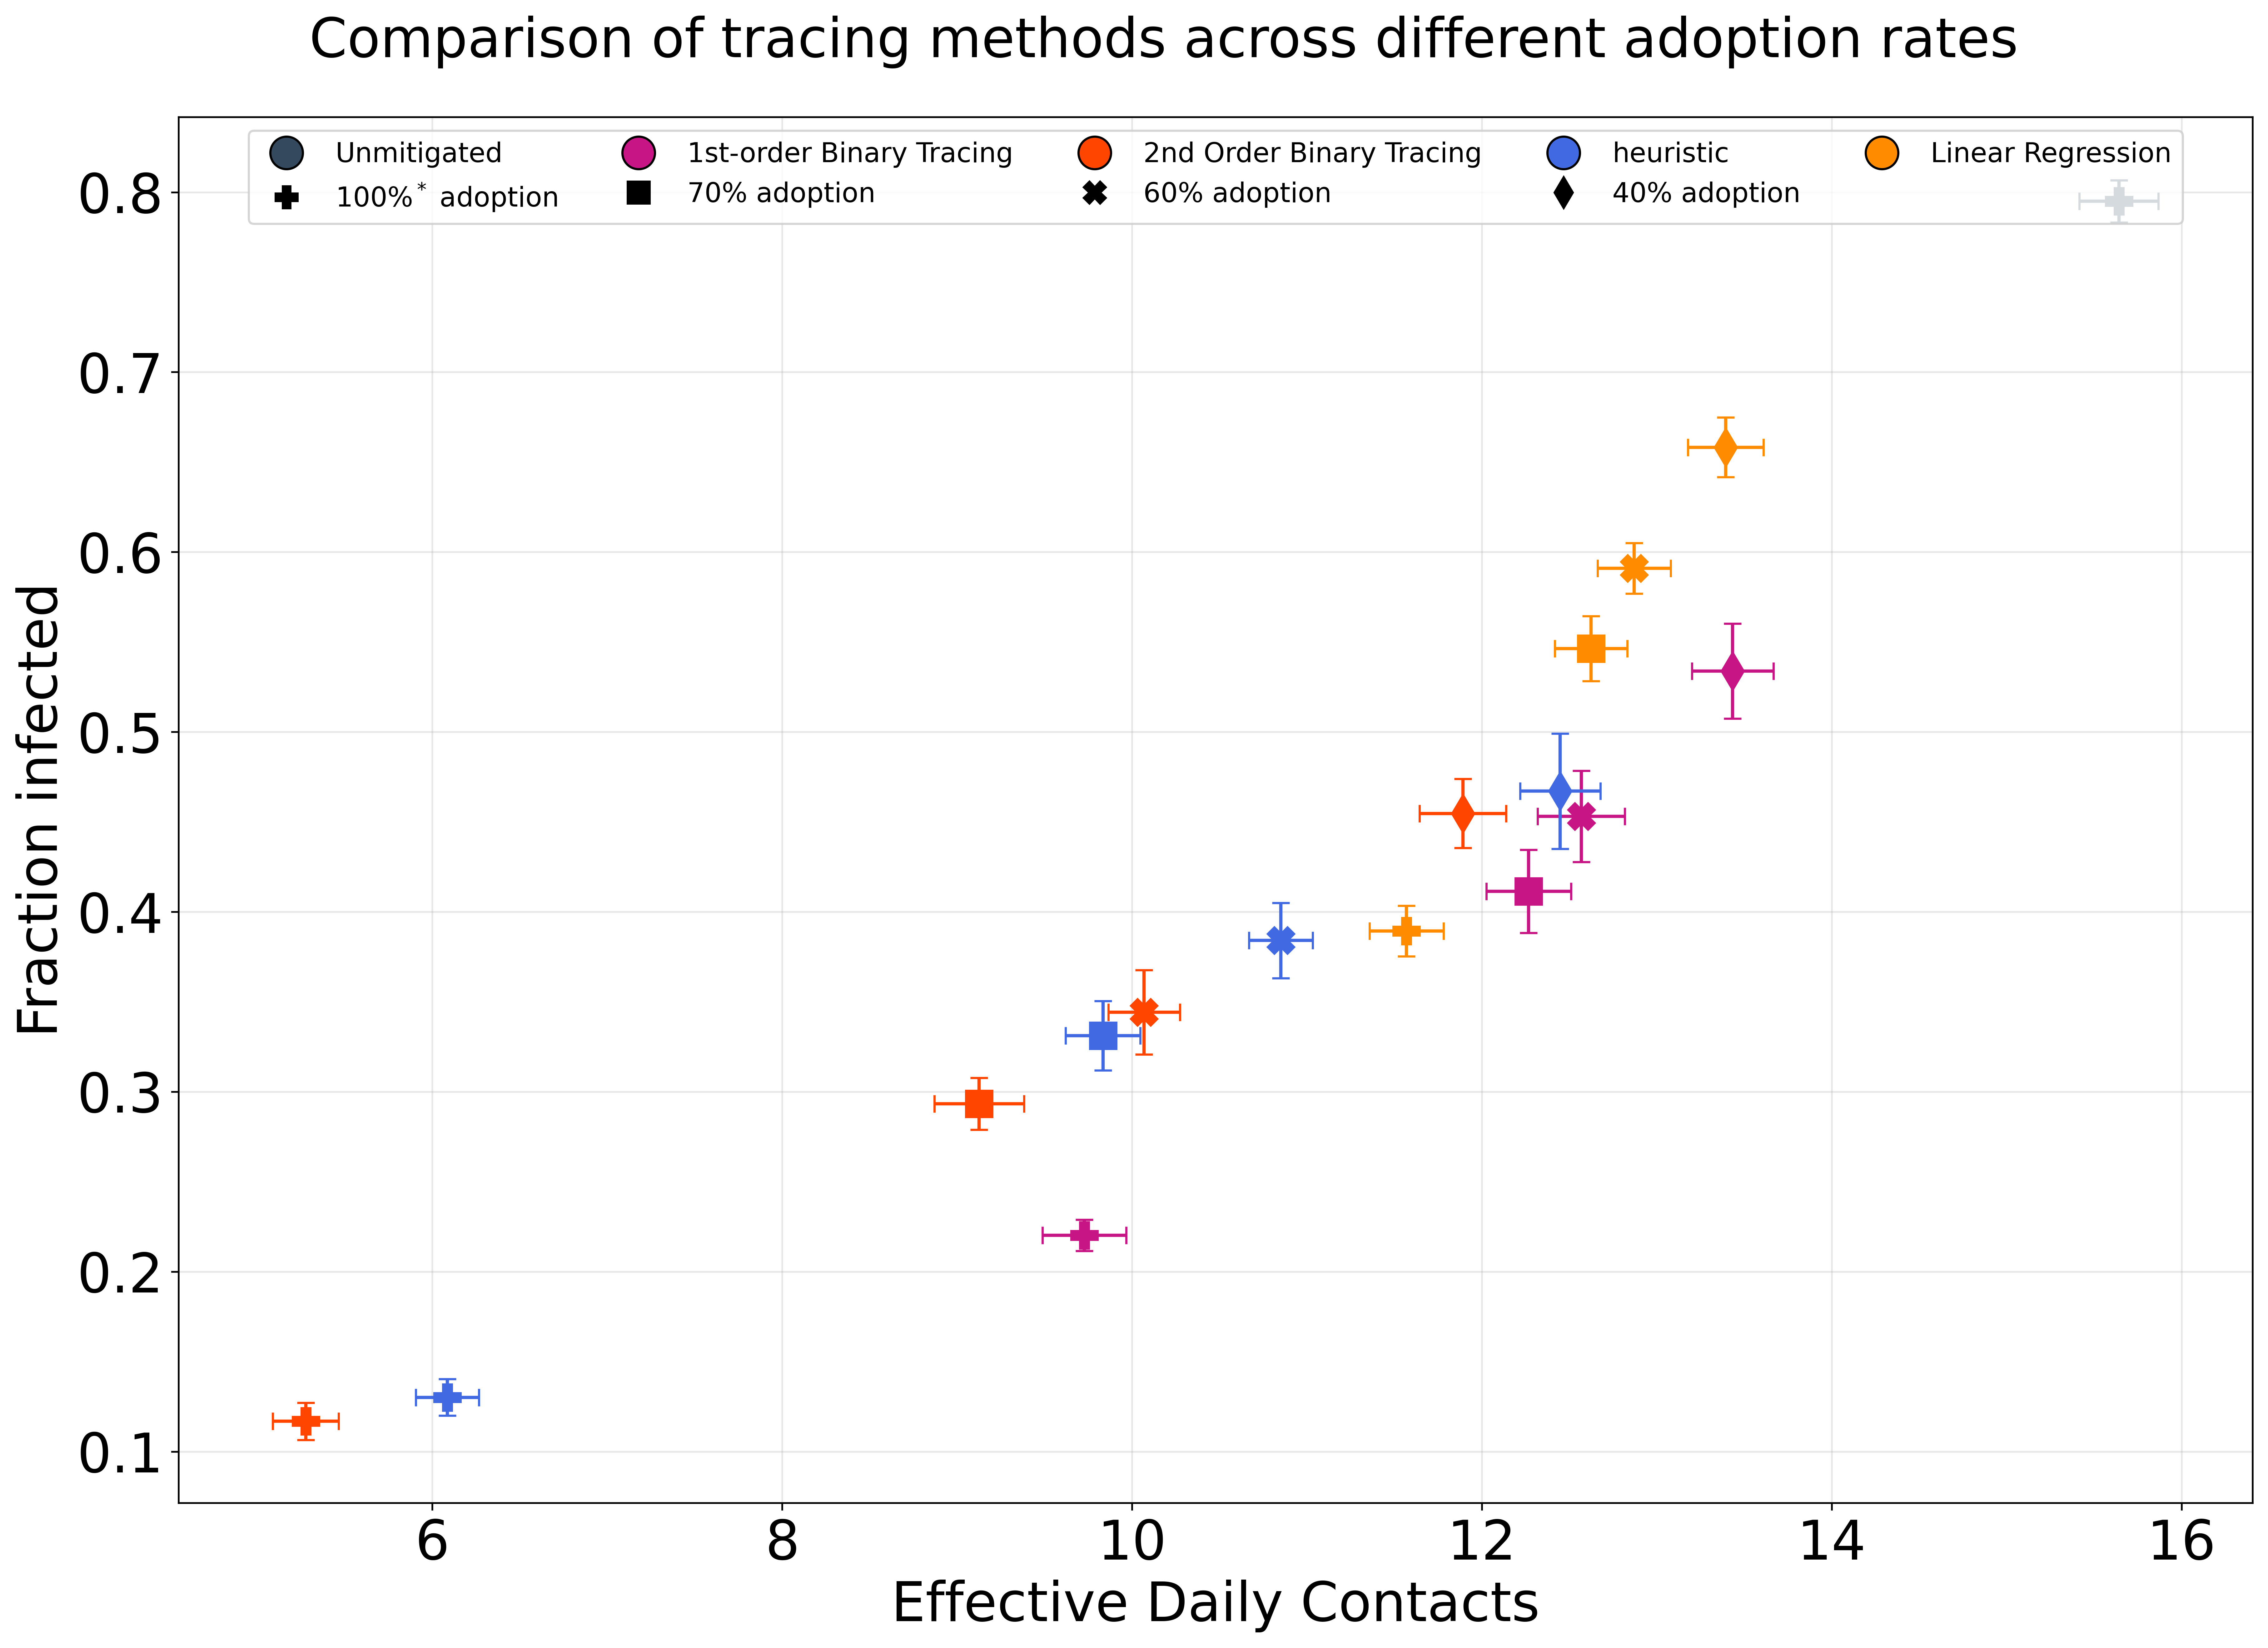

In [29]:
xmetric =  "effective_contacts" #"f1", "effective_contacts", "outside_daily_contacts", "f2", "f3", "f1_up", "f2_up"
ymetric = "percent_infected" # "percent_infected", "proxy_r", "r"

ms = 6*2
capsize = 4
markers = ['P', 's', 'X', 'd', '.']

colormap = ["#34495e",  "mediumvioletred", "orangered", "royalblue", "darkorange", "green", "red"]

fig, ax = plt.subplots(figsize=(15,10), dpi=500)

# unmitigated
idx = 0
x, xe = get_metrics(data, "unmitigated", xmetric)
y, ye = get_metrics(data, "unmitigated", ymetric)

ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[idx], ms=ms, label="unmitigated")


idx = 1
for i, label in enumerate(['bdt1', 'bdt1_70','bdt1_60', 'bdt1_40']):
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

idx = 1
for i, label in enumerate(['bdt1_norm', 'bdt1_70_norm','bdt1_60_norm', 'bdt1_40_norm']):
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label, alpha=0.4)

    
idx = 2
for i,label in enumerate(['bdt2', 'bdt2_70','bdt2_60', 'bdt2_40']):    
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

idx = 2
for i,label in enumerate(['bdt2_norm', 'bdt2_70_norm','bdt2_60_norm', 'bdt2_40_norm']):    
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label, alpha=0.4)
    
    
idx = 3
for i, label in enumerate(['heuristic', 'heuristic_70', 'heuristic_60', 'heuristic_40']):
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

idx = 4
for i, label in enumerate(['transformer', 'transformer_70', 'transformer_60', 'transformer_40']):
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

# idx = 3
# for i, label in enumerate(['transformerB_70', 'transformerB_60', 'transformerB_40']):
#     x, xe = get_metrics(data, label, xmetric)
#     y, ye = get_metrics(data, label, ymetric)
#     ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
#                      capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

# idx = 4
# for i, label in enumerate(['linear_70', 'linear_60', 'linear_40']):
#     x, xe = get_metrics(data, label, xmetric)
#     y, ye = get_metrics(data, label, ymetric)
#     ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
#                      capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)
    
# legends 
legend = [
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='#34495e', markersize=15, label='Unmitigated'),
    Line2D([0], [0], color='none', lw=2, marker='P', markerfacecolor='black', markersize=10, label='100%$^*$ adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='mediumvioletred', markersize=15, label='1st-order Binary Tracing'),
    Line2D([0], [0], color='none', lw=2, marker='s', markerfacecolor='black', markersize=10, label='70% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='orangered', markersize=15, label='2nd Order Binary Tracing'),
    Line2D([0], [0], color='none', lw=2, marker='X', markerfacecolor='black', markersize=10, label='60% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='royalblue', markersize=15, label='heuristic'),
    Line2D([0], [0], color='none', lw=2, marker='d', markerfacecolor='black', markersize=10, label='40% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='darkorange', markersize=15, label='Linear Regression'),
]
ax.legend(handles=legend, loc='upper center', ncol=5, fontsize=12.5)

# grids 
ax.grid(True, axis='x', alpha=0.3)
ax.grid(True, axis='y', alpha=0.3)

plt.xticks(size=25)
plt.yticks(size=25)
# plt.xlabel('Fraction incorrectly quarantined',size=25)
if xmetric == "f3":
    plt.xlabel('False Quarantine',size=25)
elif xmetric == "effective_contacts":
    plt.xlabel('Effective Daily Contacts',size=25)
elif xmetric == "outside_daily_contacts":
    plt.xlabel('Outside Daily Contacts',size=25)

if ymetric == "percent_infected":
    plt.ylabel('Fraction infected', size=25)

elif ymetric == "proxy_r":
    ax.plot([0,1.0], [1.0, 1.0], '-.', c="gray", alpha=0.3, label='Rt = 1.0')
    plt.ylabel('Proxy $\hat{R_t}$', size=16)

elif ymetric == "r":
    ax.plot([0,1.0], [1.0, 1.0], '-.', c="gray", alpha=0.3, label='Rt = 1.0')
    plt.ylabel('$R_t$', size=16)

fig.suptitle("Comparison of tracing methods across different adoption rates", fontsize=25, y=1.05)

plt.tight_layout()


In [50]:
fig.savefig("normalized-pareto-adoption-effective_contacts-30")